<blockquote>
    <h1>Exercise 3.9</h1>
    <p>This question involves the use of multiple linear regression on the <code>Auto</code> data set.</p>
    <ol type="I">
        <li>Produce a scatterplot matrix which includes all of the variables in the data set.</li>
        <li>Compute the matrix of correlations between the variables using the function <code>cor()</code>. You will need to exclude the $\mathrm{name}$ variable, which is qualitative.</li>
        <li>
            Use the <code>lm()</code> function to perform a multiple linear regression with $\mathrm{mpg}$ as the response and all the other variables except $\mathrm{name}$ as the predictors. Use the <code>summary()</code> function to print the results. Comment on the output. For instance:
            <ol>
                <li>Is there a relationship between the predictors and the response?</li>
                <li>Which predictors appear to have a statistically significant relationship to the response?</li>
                <li>What does the coefficient for the $\mathrm{year}$ variable suggest?</li>
            </ol>
        </li>
        <li>Use the <code>plot()</code> function to produce diagnostic plots of the linear regression fit. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers? Does the leverage plot identify any observations with unusually high leverage?</li>
        <li>Use the <code>*</code> and <code>:</code> symbols to fit linear regression models with interaction effects. Do any interactions appear to be statistically significant?</li>
        <li>Try a few different transformations of the variables, such as $\log \left( X \right)$, $\sqrt{X}$, $X^2$. Comment on your findings.</li>
    </ol>
</blockquote>

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

%run ../../customModules/usefulFunctions.ipynb
# https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# https://markthegraph.blogspot.com/2015/05/using-python-statsmodels-for-ols-linear.html
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

<h2>Data Exploration</h2>
<p>We first read the comma-separated values (csv) <code>Auto</code> file into a pandas DataFrame, for which we will show the top five rows.</p>

In [2]:
df = pd.read_csv("../../DataSets/Auto/Auto.csv")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


<p>Since the $\mathrm{name}$ variable is qualitative, we will set it as an index of the DataFrame. Furthermore, we know from our <a href="../../DataSets/Auto/Exploration.ipynb">Eploration notebook</a> for the <code>Auto</code> file that <code>horsepower</code> column contains $5$ missing values identified by the <code>'?'</code> string.</p>

In [3]:
df = df.set_index('name')
df[df['horsepower'] == '?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
ford pinto,25.0,4,98.0,?,2046,19.0,71,1
ford maverick,21.0,6,200.0,?,2875,17.0,74,1
renault lecar deluxe,40.9,4,85.0,?,1835,17.3,80,2
ford mustang cobra,23.6,4,140.0,?,2905,14.3,80,1
renault 18i,34.5,4,100.0,?,2320,15.8,81,2


<p>As explained in the <a href="../../DataSets/Auto/Exploration.ipynb">Eploration notebook</a>, we will <i>coercively</i> convert the <code>horsepower</code> column from an <code>object</code> type to a <code>numeric</code> type using pandas <code>to_numeric()</code> method. This will cause all the <code>'?'</code> strings to be converted to <code>NaN</code> values. Finally, we will use the <code>dropna()</code> method to remove the rows with missing values.</p>

In [4]:
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df.dropna(inplace=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165.0,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150.0,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150.0,3433,12.0,70,1
ford torino,17.0,8,302.0,140.0,3449,10.5,70,1


<h3>Exercise 3.9.1</h3>
<blockquote>
    <i>Produce a scatterplot matrix which includes all of the variables in the data set.</i>
</blockquote>

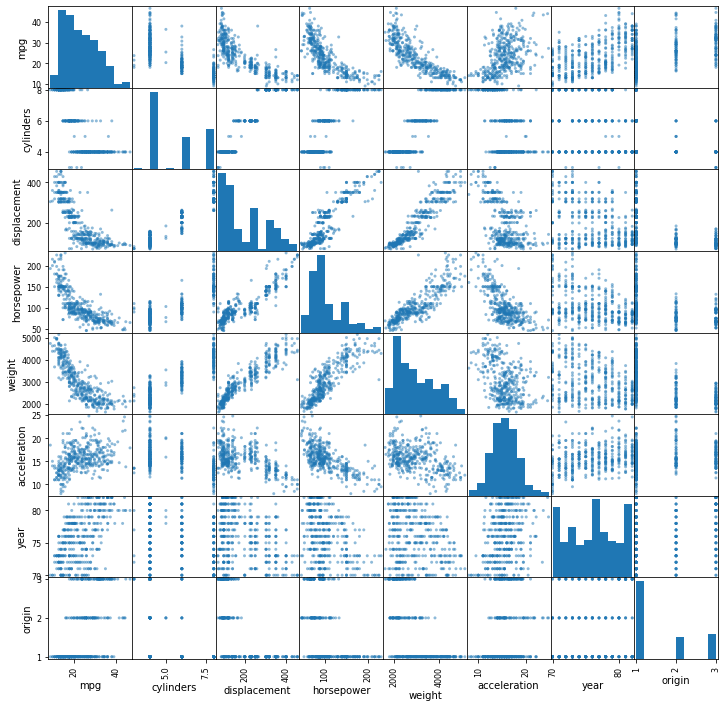

In [5]:
_ = pd.plotting.scatter_matrix(df, figsize=(12, 12))

<h3>Exercise 3.9.2</h3>
<blockquote>
    <i>Compute the matrix of correlations between the variables using the function <code>cor()</code>. You will need to exclude the $\mathrm{name}$ variable, which is qualitative.</i>
</blockquote>

In [6]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1,-0.78,-0.81,-0.78,-0.83,0.42,0.58,0.57
cylinders,-0.78,1,0.95,0.84,0.9,-0.5,-0.35,-0.57
displacement,-0.81,0.95,1,0.9,0.93,-0.54,-0.37,-0.61
horsepower,-0.78,0.84,0.9,1,0.86,-0.69,-0.42,-0.46
weight,-0.83,0.9,0.93,0.86,1,-0.42,-0.31,-0.59
acceleration,0.42,-0.5,-0.54,-0.69,-0.42,1,0.29,0.21
year,0.58,-0.35,-0.37,-0.42,-0.31,0.29,1,0.18
origin,0.57,-0.57,-0.61,-0.46,-0.59,0.21,0.18,1


<h3>Exercise 3.9.3</h3>
<blockquote>
    <i>Use the <code>lm()</code> function to perform a multiple linear regression with $\mathrm{mpg}$ as the response and all the other variables except $\mathrm{name}$ as the predictors. Use the <code>summary()</code> function to print the results. Comment on the output.</i>
</blockquote>


In [7]:
df.insert(0, 'Intercept', 1)
targetColumn = ['mpg']
descriptiveColumns = removeColumnsFromList(df, targetColumn)
X = df[descriptiveColumns]
Y = df[targetColumn]
model = sm.OLS(Y, X)
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Mon, 30 Dec 2019   Prob (F-statistic):          2.04e-139
Time:                        13:01:02   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -17.2184      4.644     -3.707      0.000     -26.350      -8.087
cylinders       -0.4934      0.323     -1.526      0.128      -1.129       0.142
displacement     0.0199      0.008      2.647      0.008       0.005       0.035
horsepower      -0.0170      0.014     -1.230      0.220      -0.044       0.010
weight          -0.0065      0.001     -9.929      0.000      -0.008      -0.005
acceleration     0.0806      0.099      0.815      0.415      -0.114       0.275
year             0.7508      0.051     14.729      0.000       0.651       0.851
origin           1.4261      0.278      5.127      0.000       0.879       1.973
==============================================================================
Omnibus:                       31.906   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.100
Skew:                           0.529   Prob(JB):                     2.95e-12
Kurtosis:                       4.460   Cond. No.                     8.59e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h5>Exercise 3.9.3A</h5>
<blockquote>
    <i>Is there a relationship between the predictors and the response?</i>
</blockquote>
<p>Since the $F$-statistic is much larger than $1$ with a very small $p$ value, we can conclude that there is indeed a large probability that there is relationship between the response and at least one of the predictors.</p>

<h5>Exercise 3.9.3B</h5>
<blockquote>
    <i>Which predictors appear to have a statistically significant relationship to the response?</i>
</blockquote>
<p>Looking at the magnitude of the slope coefficients in combination with the $p$ values, we see that there is a significant chance that $\mathrm{cylinders}$ (perhaps), $\mathrm{displacement}$, $\mathrm{weight}$, $\mathrm{year}$ and $\mathrm{origin}$ predictors are related to the response variable.</p>

<h5>Exercise 3.9.3C</h5>
<blockquote>
    <i>What does the coefficient for the $\mathrm{year}$ variable suggest?</i>
</blockquote>
<p>For every year that the car is newer, the $\mathrm{mpg}$ is predicted to increase by $0.7508$.</p>

<h3>Exercise 3.9.4</h3>
<blockquote>
    <i>Use the <code>plot()</code> function to produce diagnostic plots of the linear regression fit. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers? Does the leverage plot identify any observations with unusually high leverage?</i>
</blockquote>


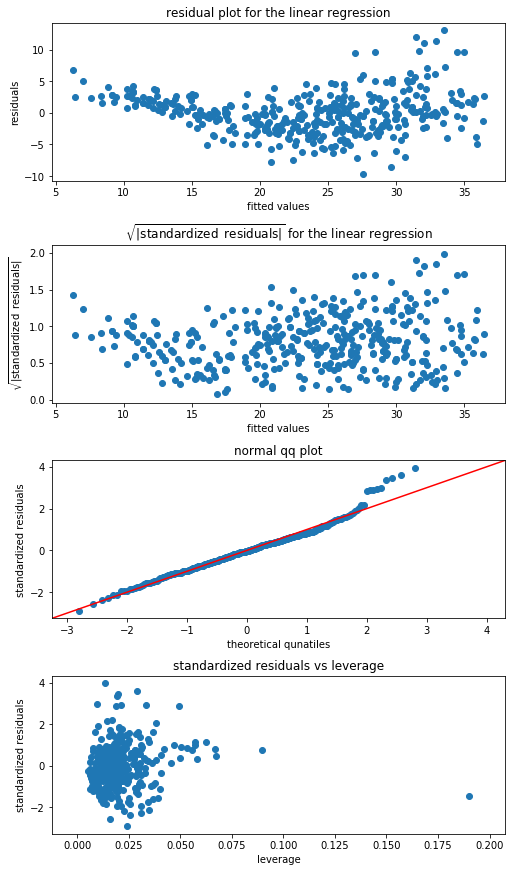

In [8]:
createResidualPlots(X, Y)

<p>The residual plots show that there is non-linear structure, indicating that the linear model is underfitting the data. The qq plot shows that the distribution of the standardized residuals is approximately normal except for the divergence at the right tail, indicating the distibution is slightly skewed to the right. The leverage plot shows that there is one sample point with a unusual high leverage, although it is not an outlier</p>

<h3>Exercise 3.9.4</h3>
<blockquote>
    <i>Use the <code>*</code> and <code>:</code> symbols to fit linear regression models with interaction effects. Do any interactions appear to be statistically significant?</li>
</blockquote>

    
    